# Demand Forecasting Predictions 

***Let's get started.***

![Walmart](https://nypost.com/wp-content/uploads/sites/2/2019/08/walmart-tesla.jpg?quality=80&strip=all&w=618&h=410&crop=1)

## Info

* This notebook is for the capstone project for Udacitys Nanodegree - **Machine Learning Engineer**. More information about the project will be provided below. 

* To test the prediciton score, we will submit the predictions to the Kaggle competition by Walmart which the data originated from, see link [here](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/overview). 

# Structure 

1. Import libraries and set up Dataframes
2. Explore the Data
3. Create Train & Test Data
4. Set up Benchmark Model Score
5. Create & Test models 
6. Summary of Results & Pick winning model for submission
7. Submission Score & Comparison to Benchmark

# 1. Import Libraries & Set up Data

**The first stage.**

![Kaggle](https://dox4euoyzny9u.cloudfront.net/images/blog/uploads/dataprocessinggdpr.jpg)

### What will we will do in this section?

* In this section we will import the nessessary libraries and the data from kaggle.com. 
* Link to dataset **[here](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/overview).**

* We will then proceed and create dataframes (df's) that match each other, so we can try to answer the final question of; ***Predict the department-wide sales for each store***.


### Libraries to import

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#from lofo import LOFOImportance # https://github.com/aerdem4/lofo-importance
%matplotlib inline
plt.style.use('seaborn-whitegrid')
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime
import math
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor

### Data to import

In [ ]:
# Import data
df_f = pd.read_csv("../input/walmart-recruiting-store-sales-forecasting/features.csv.zip")
df_st = pd.read_csv("../input/walmart-recruiting-store-sales-forecasting/stores.csv")
df_train = pd.read_csv("../input/walmart-recruiting-store-sales-forecasting/train.csv.zip")
df_test = pd.read_csv("../input/walmart-recruiting-store-sales-forecasting/test.csv.zip")


# check the data
df_test.head(3)
#df_test.shape

In [ ]:
# Make date column into datetime
df_f["Date"] = pd.to_datetime(df_f["Date"])
df_train["Date"] = pd.to_datetime(df_train["Date"])
df_test["Date"] = pd.to_datetime(df_test["Date"])

# Test if it works
print(df_train[0:1].Date, df_train[-1:].Date)
print(df_test[0:1].Date, df_test[-1:].Date)
print(df_f[0:1].Date, df_f[-1:].Date)

In [ ]:
# Assess the total amount of columns and rows in a more consise way
print(df_f.shape)
print(df_train.shape)
print(df_test.shape)
print(df_st.shape)

##### What do we know about our data so far?
* So we can see we are working with over 421 570 rows of data in the train dataframe, over 5 columns. This looks like it's this large due to the fact of the 45 different stores. 

* Moreover, for our test data we have 115 063 rows of data over 5 columns. 


* Then we have 8190 rows of data over 12 different columns in the Features dataframe. 

* Finally we have 45 rows of data over 3 columns in the stores dataframe. 

***Next** we will proceed to address the NaN values we could identify in the .head() formula above.*

### Merge data into 1 DataFrame

We do this to get some assistance in assessing the features and the time when we proceed with the modeling. 

In [ ]:
# Merging training data
df_all_train = df_train.merge(df_f, how="left", on=["Store","Date","IsHoliday"])
#df_all_train.head(3)

# Merging test data
df_all_test = df_test.merge(df_f, how="left", on=["Store","Date","IsHoliday"])
df_all_test.tail(3)


In [ ]:
# More merging of training data
df_all_train = df_all_train.merge(df_st, how="left", on=["Store"])
df_all_train.head(3)

# More merging of test data
df_all_test = df_all_test.merge(df_st, how="left", on=["Store"])
#df_all_test.head(3)


In [ ]:
# Check how our final df_all_train looks
print("Rows & Columns: ", df_all_train.shape, "\nAll columns if the df: ", df_all_train.columns.tolist())

# # Check how our final df_all_test looks
print("Rows & Columns: ", df_all_test.shape, "\nAll columns if the df: ", df_all_test.columns.tolist())


### What is in our new *df_all* dataframe?

* **What is included?** All columns from the three original files are now in the same dataframe, being; *'Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size'*
* **Why do it this way?** We got everything in the same df now to proceed to fix NaN values etc to keep everything at the same place. If we need specific columns, we don't need to go through specific files, we have everything at the same place, which makes it easier to keep in check. 

In [ ]:
df_all_train = df_all_train.applymap(lambda x: 1 if x == True else x)
df_all_train = df_all_train.applymap(lambda x: 0 if x == False else x)

df_all_test = df_all_test.applymap(lambda x: 1 if x == True else x)
df_all_test = df_all_test.applymap(lambda x: 0 if x == False else x)

In [ ]:
# Checking the DFs
df_all_train.head(3)
#df_all_test.head(3)

### Deal with NaN values 

In [ ]:
# Check where we find NaN values

tab_info = pd.DataFrame(df_all_train.dtypes).T.rename(index={0:'column Type'}) 
tab_info = tab_info.append(pd.DataFrame(df_all_train.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info = tab_info.append(pd.DataFrame(df_all_train.isnull().sum()/df_all_train.shape[0]*100).T.
                                       rename(index={0: 'null values (%)'}))
tab_info

In [ ]:
#replace Temperature, fule price, CPI and unemployment with averages. 
# This seems more reasonable than replacing them with "0"s.                                                
df_all_train[["Temperature"]] = df_all_train[["Temperature"]].fillna(df_all_train[["Temperature"]].mean())
df_all_train[["Fuel_Price"]] = df_all_train[["Fuel_Price"]].fillna(df_all_train[["Fuel_Price"]].mean())
df_all_train[["CPI"]] = df_all_train[["CPI"]].fillna(df_all_train[["CPI"]].mean())
df_all_train[["Unemployment"]] = df_all_train[["Unemployment"]].fillna(df_all_train[["Unemployment"]].mean())

df_all_test[["Temperature"]] = df_all_test[["Temperature"]].fillna(df_all_test[["Temperature"]].mean())
df_all_test[["Fuel_Price"]] = df_all_test[["Fuel_Price"]].fillna(df_all_test[["Fuel_Price"]].mean())
df_all_test[["CPI"]] = df_all_test[["CPI"]].fillna(df_all_train[["CPI"]].mean())
df_all_test[["Unemployment"]] = df_all_test[["Unemployment"]].fillna(df_all_test[["Unemployment"]].mean())

In [ ]:
# Check the results
df_all_train.head(3)

In [ ]:
# Replace the NaN values in markdown with 0
df_all_train = df_all_train.fillna(0)
df_all_test = df_all_test.fillna(0)

In [ ]:
# Check the results
df_all_train.head(3)

In [ ]:
# Check NaN values in df_all_train

tab_info = pd.DataFrame(df_all_train.dtypes).T.rename(index={0:'column Type'}) 
tab_info = tab_info.append(pd.DataFrame(df_all_train.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info = tab_info.append(pd.DataFrame(df_all_train.isnull().sum()/df_all_train.shape[0]*100).T.
                                       rename(index={0: 'null values (%)'}))
tab_info

In [ ]:
# Check NaN values in df_all_test

tab_info = pd.DataFrame(df_all_test.dtypes).T.rename(index={0:'column Type'}) 
tab_info = tab_info.append(pd.DataFrame(df_all_test.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info = tab_info.append(pd.DataFrame(df_all_test.isnull().sum()/df_all_test.shape[0]*100).T.
                                       rename(index={0: 'null values (%)'}))
tab_info

### Create Dummy Variables for Type of Store

* We do this in order to analyse the data, as a non-numerical value will not be processed in our models.

In [ ]:
df_all_train = pd.get_dummies(df_all_train, columns=["Type"])
df_all_test = pd.get_dummies(df_all_test, columns=["Type"])

In [ ]:
# Checking the DFs after all of the processing
df_all_train.head(3)
#df_all_test.head(3)

### Done with data cleaning and processing

- We can now proceed to explore the data

______
# 2. Data Exploration

**Ways we will explore the data:**
- .describe() function - general overview
- General plots for the different features
- Get average weekly sales for each store/department
- plot of sales 
- correlation heatmap

![Data](https://codemyviews-blog-post-images.s3.amazonaws.com/uploads/machine-learning.png)

In [ ]:
# Start with simple .describe() to get the general jist of the dataframe
df_all_train.describe()

In [ ]:
# Plots for the different features in the df: 
df_all_train[['Date', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].plot(x='Date', subplots=True, figsize=(20,15))

plt.show()

### *General comments about the graphs*

* **Discounts**: We have a few spikes, but not too many to make assumptions of the affects of it. It seems like the discounts are a more recent thing appearing in the end of 2011 with the exception of the potential test of 2011-02 where we find a small bump on all discount levels.
* **Temperature**: it seems like it is decently seasonal, which sounds reasonable when we talk about temperature on a YoY basis. 
* **Fuel Price**: Seems to have a slight positive trend. 
* **Unemployment**: Seems to have a slight negative trend over this timeframe. 

____
### Weekly sales plot

In [ ]:
# Average weekly sales for the stores/departments during a week
df_average_sales_weekly = df_all_train.groupby(by=["Date"], as_index = False)["Weekly_Sales"].sum()

df_average_sales = df_average_sales_weekly.sort_values("Weekly_Sales", ascending=False)

#print(df_average_sales[:10])

plt.figure(figsize=(20,5))
plt.plot(df_average_sales_weekly.Date, df_average_sales_weekly.Weekly_Sales)
plt.show

### *General comments about the graph* 

* **Seasonality - *High-Point***: It seems there are some seasonality to our data, where the end of December seems like a popular time to buy our company's specific products. Hy theory is that this has to do with the holidays and people buy gifts for each other, which seems reasonable. 
* **Seasonality - *Low-Point***: Around the end of january it seems to be a pretty steep dip in the different stores sales both during 2011 and 2012. 

#### Creating dummy variables for each month 

In [ ]:
df_all_train["month"] = df_all_train['Date'].dt.month
df_all_train = df_all_train.drop(["Date"], axis=1)
df_all_train = pd.get_dummies(df_all_train, columns=["month"])#, prefix='month')
#df_all_train = df_all_train.drop('Date', 1)

df_all_test["month"] = df_all_test['Date'].dt.month
df_all_test = df_all_test.drop(["Date"], axis=1)
df_all_test = pd.get_dummies(df_all_test, columns=["month"])#, prefix='month')
#df_all_test = df_all_test.drop('Date', 1)

### Correlation heat map

In [ ]:
# Correlation between all features
sns.heatmap(df_all_train.corr())

In [ ]:
# Correlation between Weekly Sales and all other features
df_all_train_corr = df_all_train[df_all_train.columns[:]].corr()['Weekly_Sales'][:]
df_all_train_corr = df_all_train_corr.drop("Weekly_Sales")
df_all_train_corr

In [ ]:
# Plot the correlation 
df_all_train_corr.plot.bar()

### General comments about the graph
The correlation table and graph indicate a few things: 
* **MarkDowns**: Not that significant in terms of weekly sales
* **Size**: Highest correlation of all, telling us that having a larger store = more sales. Only thing to notice is that this could imply that having larger stores will automatically increase revenues, but it could be linked to the location and being situated where a lot of people are, and therefore it results in higher revenue. In short, we can apply the old saying "Correlation is not causation". But it will b
* **Type**: Type_A seems to have a positive correlation with the 
* **Department**: Positive correlation with sales as well. 

_______
# 3. Create Train & Test Data.

**Making the data ready to use in our models.**

![data](https://www.kaggle.com/static/images/host-home/host-home-research.png)

In [ ]:
# DF x & y
train_all = df_all_train # make it shorter syntax

train_X = df_all_train.drop(["Weekly_Sales", "month_8", "month_9", "month_10"], axis=1)
train_y = train_all["Weekly_Sales"]
test_X = df_all_test # making the syntax shorter --> Sub = submission

X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, shuffle=False, stratify=None)

#### Check so that the dfs looks alright.

In [ ]:
#X_train.shape
#X_test.shape

X_train.head(3)
#y_train.head(3)

#X_test.head(3)
#y_test.head(3)

#test_X.head(3)

_______
# 4. Benchmark

**How will we benchmark our results?**

![ML](https://www.kaggle.com/static/images/about/inclass/howitworks@2x.png)

* The initial benchmarking will be made by looking at three different metrics used for estimating errors, as well as one statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. These are: 

**Error Metrics:**
1. Mean Absolute Error (MAE)
2. Mean Sqared Error (MSE)
3. Root Mean Squared Error (RMSE)

**Model Valuation Metric *(robustness of the model):***
1. R-squared (R^2)

### Kaggle Score Comparison Benchmark

The final benchmark after selecting our best model will be to use it and compare it to roughly the 50th percentile score, which looks to be around **4000 points**. A competitor close to this that we should beat is "Hari Khanal", with the score of **3985.79966**.

* **GOAL:** Get a lower score than Hari. 
* The lower the score, the better the prediction.


You'll find the link to the scoreboard [here](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/leaderboard). 

______
# 5. Modeling

***Finding the best model.***

![ML](https://www.kth.se/polopoly_fs/1.862339.1554801965!/image/startpuff-avdelning_matematisk%20statistik.jpg)


#### We will limit this test to 8 different models:

1. Linear Regression (Linear model)
2. KNeighborsRegressor (KNN) (neighbors model)
3. Decision Tree Regressor (Tree model)
4. Random Forest Regressor (Enemble model)
5. Extra Trees Regressor (Ensemble model)
6. XGBoost (gradient boosted decision trees)
7. Ridge (Linear model)
8. Lasso (Linear model)


*We will start by creating train, test and final datasets.*



_____
## Linear Regression

In [ ]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [ ]:
# Print out the MAE, MSE & RMSE
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred)) #MAE
print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

# rSquared
score = r2_score(y_test, y_pred)
print("R^2:", score)

_______
## KNN Regressor 

In [ ]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [ ]:
from sklearn import metrics

# Print out the MAE, MSE & RMSE
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred)) #MAE
print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

# rSquared
score = r2_score(y_test, y_pred)
print("R^2:", score)

_______
## Decision Tree Regressor

In [ ]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

In [ ]:
# Print out the MAE, MSE & RMSE
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred)) #MAE
print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

# rSquared
score = r2_score(y_test, y_pred)
print("R^2:", score)

_____
## Random Forest Regressor

In [ ]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [ ]:
# Print out the MAE, MSE & RMSE
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred)) #MAE
print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

# rSquared
score = r2_score(y_test, y_pred)
print("R^2:", score)

_____

## Extra Trees Regressor

In [ ]:
etr_random_best = ExtraTreesRegressor(bootstrap=False, criterion="mse", max_depth=None,
                                      max_features="auto", max_leaf_nodes=None,
                                      min_impurity_decrease=0.0, min_impurity_split=None,
                                      min_samples_leaf=2, min_samples_split=5,
                                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=30,
                                      oob_score=False, random_state=None, warm_start=False)
etr_random_best.fit(X_train, y_train)

In [ ]:
y_pred = etr_random_best.predict(X_test)

In [ ]:
# Print out the MAE, MSE & RMSE
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred)) #MAE
print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

# rSquared
score = r2_score(y_test, y_pred)
print("R^2:", score)

______
## XGBoost

In [ ]:
xg = XGBRegressor()
xg.fit(X_train, y_train)
y_pred = xg.predict(X_test)

In [ ]:
# Print out the MAE, MSE & RMSE
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred)) #MAE
print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

# rSquared
score = r2_score(y_test, y_pred)
print("R^2:", score)

________
## Ridge

In [ ]:
rid = Ridge()
rid.fit(X_train, y_train)
y_pred = rid.predict(X_test)

In [ ]:
# Print out the MAE, MSE & RMSE
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred)) #MAE
print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

# rSquared
score = r2_score(y_test, y_pred)
print("R^2:", score)

________
## Lasso

In [ ]:
las = Lasso()
las.fit(X_train, y_train)
y_pred = las.predict(X_test)

In [ ]:
# Print out the MAE, MSE & RMSE
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred)) #MAE
print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

# rSquared
score = r2_score(y_test, y_pred)
print("R^2:", score)

________

# 6. Summarising Results & Optimal Model

**The #1 model.**

![Model](https://png.pngtree.com/template/20190214/ourlarge/pngtree-aquare-letter-d-and-number-one-logo-vector-image_55711.jpg)

### ACCUARY 
#### Best performer 

* Extra Trees Regressor
    * MAE:  3576.95
    * MSE:  54517368.39
    * RMSE:  7383.58

#### Worst performer

* Ridge Regressor
    * MAE:  11791.42
    * MSE:  338620263.35
    * RMSE:  18401.64
___
### MODEL ROBUSTNESS 
#### Best performer 

* Extra Trees Regressor
    * R^2 = 0.85

#### Worst performer

* Linear Regression
    * R^2 = 0.06
___

## AND THE OVERALL WINNER IS...

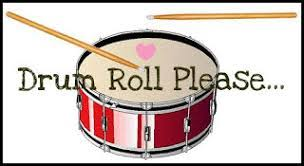

# --> Extra Trees Regressor! <---

______
### Final comments about the models

* **Linear models:** We find that the three linear models were not close to assist in the predictions with a R^2 score of less than 0.1.

_______

# 7. Submission Score & Comparison to Benchmark

***The final stop.***

![put](https://miro.medium.com/max/1200/1*joDRjoQDx4nJ4R8R5YkfoA.jpeg)

### Print the predictions for the final submission

In [ ]:
y_pred = etr_random_best.predict(test_X) # Un-test data for the final submission

In [ ]:
#pred = pd.DataFrame(y_pred.astype(str))
pred["Weekly_Sales"] = pd.DataFrame(y_pred.astype(str))

In [ ]:
pred.head(3)

In [ ]:
Id = pd.DataFrame(df_test[["Store", "Dept","Date"]])
Id.head(3)

In [ ]:
Id["Id"] = Id["Store"].astype(str) + "_" + Id["Dept"].astype(str) + "_" + Id["Date"].astype(str)
Id.head(3)

In [ ]:
Id = pd.DataFrame(Id["Id"])
Id.head(3)

In [ ]:
#submission = pd.DataFrame(Id["Id"]) + pd.DataFrame(pred["Weekly_Sales"])
#submission = pd.concat([Id["Id"], pred["Weekly_Sales"]])
#submission pd.DataFrame({'date':df.date,'Anomaly':tmp.Anomaly.combine_first(df.Anomaly)}
#submission = pd.DataFrame({})
submission = pd.concat([Id,pred["Weekly_Sales"]], axis = 1)

In [ ]:
#submission.head(3)
submission.shape # Needs to be 115064 predicitons according to the competition

### Create CSV

In [ ]:
submission.to_csv("Weekly_Sales_Prediction.csv", index=False)

_____
# Results Score from Kaggle

* We get a score of ***3883.47399*** which puts us in a better spot than our benchmark: Hari Khanal", with the score of ***3985.79966.*** 


## *WE DID IT!*

## Final thoughts

* This project was incredibly fun and spending over 60 hours on it was without a doubt definitely worth it. 

Cheers. 

![celebrate](https://www.pblworks.org/sites/default/files/inline-images/celebration.jpg)